In [1]:
import numpy as np
import pandas as pd
import json as json
import pickle as pk
from ast import literal_eval
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import math as math
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import random as rand
import warnings
import itertools
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: Data Analysis

1. The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them. We’re looking for people who can “tell the data story:” use empirical evidence to make product decisions and develop effective decision systems.
2. Suppose you’re tasked with predicting the amount of demand for trips in a particular area of a city. These predictions can be used in a variety of ways, including pricing decisions and optimizing the utilization of drivers. Based on the insights you developed above, describe a method to forecast expected future demand at the same 15-minute granularity over the following hour (the 4 following time periods). Apply your method to this dataset, and evaluate its predictive accuracy in a reasonable way. Discuss your method and its accuracy.
3. Not only are accurate mean predictions important, but so are appropriate characterizations of the stochastic nature of this demand. If not already done in part 2, describe a method to predict the probability distribution of demand in the following 15-minute period. Describe how you would evaluate accuracy of these stochastic predictions. You don’t have to apply your method to the dataset.

## Data Preparation

I first read the data and convert the login times which are stored as strings into date-time formats. The data is sorted. I also find the start time (start_time) and the end time (end_time) for logins . I aggragte the login times into 15-min intervals starting from 2010-01-01 00:00:00. I store the aggregate data in a dictionary - called *fif_min_login* with keys as the beginning of an interval and the values as the number of logins in the next 15 minutes. I put the login times in a data frame and call it *df*  to use it in an easier way later.

I also convert the obtained dictnoary into a data frame, called *fif_df*, and extract time informations from each time interval.

In [2]:
with open('./logins2.json',  'r') as d:
    data = json.load(d)
data = json.dumps(data)
data = literal_eval(data)
data = data['login_time']

times = []
for i in data:
    t = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
    times.append(t)
    
times = sorted(times)
start_time = min(times)
end_time = max(times)

# print 'Number of logins: ', len(times)
# print 'Start time: ', start_time
# print 'End time', end_time

In [4]:
data

['2010-01-01 00:11:52',
 '2010-01-01 00:13:00',
 '2010-01-01 00:14:49',
 '2010-01-01 00:21:00',
 '2010-01-01 00:23:05',
 '2010-01-01 00:29:00',
 '2010-01-01 00:30:00',
 '2010-01-01 00:30:36',
 '2010-01-01 00:32:00',
 '2010-01-01 00:33:00',
 '2010-01-01 00:36:40',
 '2010-01-01 00:36:55',
 '2010-01-01 00:41:00',
 '2010-01-01 00:48:17',
 '2010-01-01 00:50:49',
 '2010-01-01 00:51:00',
 '2010-01-01 00:53:00',
 '2010-01-01 00:56:00',
 '2010-01-01 00:57:00',
 '2010-01-01 00:57:35',
 '2010-01-01 01:01:00',
 '2010-01-01 01:01:37',
 '2010-01-01 01:02:07',
 '2010-01-01 01:08:32',
 '2010-01-01 01:09:00',
 '2010-01-01 01:16:00',
 '2010-01-01 01:18:47',
 '2010-01-01 01:21:00',
 '2010-01-01 01:27:34',
 '2010-01-01 01:29:07',
 '2010-01-01 01:32:30',
 '2010-01-01 01:35:36',
 '2010-01-01 01:36:00',
 '2010-01-01 01:36:41',
 '2010-01-01 01:38:00',
 '2010-01-01 01:41:10',
 '2010-01-01 01:41:33',
 '2010-01-01 01:50:00',
 '2010-01-01 01:53:29',
 '2010-01-01 01:55:03',
 '2010-01-01 01:56:00',
 '2010-01-01 01:

In [3]:
# 15 min interval aggregation
fif_min_login = {}

s = datetime(2010, 1, 1, 0, 0, 0)

while s < end_time:
    fif_min_login.setdefault(s,0)
    s += timedelta(minutes=15)
    
# print 'Number of 15-min intervals: ', len(fif_min_login)

df = pd.DataFrame(columns=['login_time'], index=np.arange(0, len(times),1))
df.login_time = times

In [6]:
df.tail()

,login_time
97418,2010-08-28 14:38:00
97419,2010-08-28 14:38:39
97420,2010-08-28 14:44:25
97421,2010-08-28 14:45:34
97422,2010-08-28 14:47:00


In [6]:
# 15 min interval aggregation
fif_min_login = {}

s = datetime(2010, 1, 1, 0, 0, 0)

while s < end_time:
    fif_min_login.setdefault(s,0)
    s += timedelta(minutes=15)
    
# print 'Number of 15-min intervals: ', len(fif_min_login)

df = pd.DataFrame(columns=['login_time'], index=np.arange(0, len(times),1))
df.login_time = times

t = datetime(2010, 1, 1, 0, 0, 0)

for i in sorted(fif_min_login.keys()):
    temp = df.loc[(df.login_time >= t) & (df.login_time < t+timedelta(minutes=15))]
    fif_min_login[i] = len(temp)
    t += timedelta(minutes=15)

        
# print 'Min number of logins in a 15-min interval: ', min(fif_min_login.values())
# print 'Max number of logins in a 15-min interval: ', max(fif_min_login.values())


count_df = pd.DataFrame.from_dict(fif_min_login, orient='index' )
count_df['log_time'] = count_df.index
count_df['count'] = count_df[0]
count_df = count_df.drop([0], axis=1)
count_df.reset_index(drop = True, inplace = True)
count_df = count_df.sort_values(by = ['log_time'])
count_df.reset_index(drop = True, inplace = True)
count_df['day_month'] = count_df['log_time'].dt.strftime('%m-%d')
count_df['month'] = count_df['log_time'].dt.strftime('%m')
count_df['week_day'] = count_df.log_time.dt.dayofweek
count_df['hour'] = count_df.log_time.dt.time
count_df['day_hour'] = count_df.log_time.dt.strftime('%d %H:%M:%S')
fif_df = count_df.copy()

In [8]:
fif_df.head()

,log_time,count,day_month,month,week_day,hour,day_hour
0,2010-01-01 00:00:00,3,01-01,01,4,00:00:00,01 00:00:00
1,2010-01-01 00:15:00,3,01-01,01,4,00:15:00,01 00:15:00
2,2010-01-01 00:30:00,7,01-01,01,4,00:30:00,01 00:30:00
3,2010-01-01 00:45:00,7,01-01,01,4,00:45:00,01 00:45:00
4,2010-01-01 01:00:00,5,01-01,01,4,01:00:00,01 01:00:00


## Descriptive Analysis

I plot the number of logins in each 15-min intervals. Eventhought the plot is quite cluttered, it can be seen that the number of logins is going up and down, with zero as minimum and 18 as maximum. The plot also shows that in the beginning of Feburary and August, there is a drastic drop in the number of logins which can be due to multiple reseasons including special occasions or losing the marketplace to competitors. It also could be because of the quality of the data and the way that number of logins are captured in those times.

To have a better understanding of the daily variation in the number of logins, I pick three random days and plot the number of logins for 96 fifteen-min intervals. As shown below, these three days are more or less following a same patterns regarding the number of logins. From midnight until 5 AM, the number of logins is decreasing, hitting the minimum at around 5:30 AM. The logins are again increasing after the minimum point until reaching a local minimum at around 5 PM. 

Further, I aggregate all the login data into 96 fifteen-min interval and plot them using box plot to see the over trend across all days. It is shown that the overal pattern in the number of logins is similar to three random days that we observed first. We can also spot the outliers from the box plots for each interval. Around 10 AM, we see the least number of outliers. However, right before midnight, we observe that the variation in the number of logins is relatively larger. This could be due to the heterogeneity of the days. For instance, the logins around midnight could be different for week days and weekend.

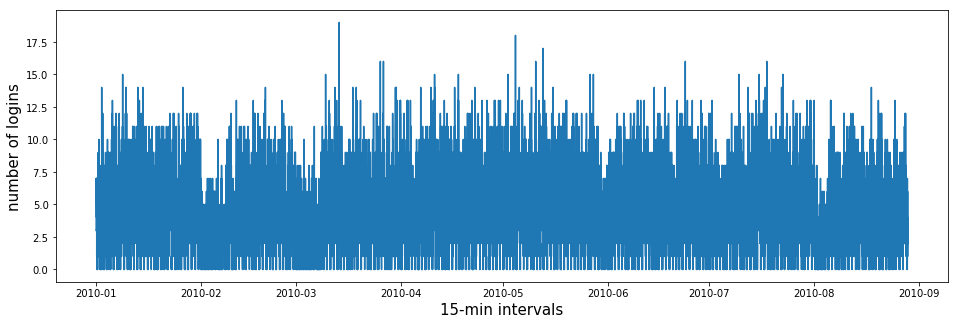

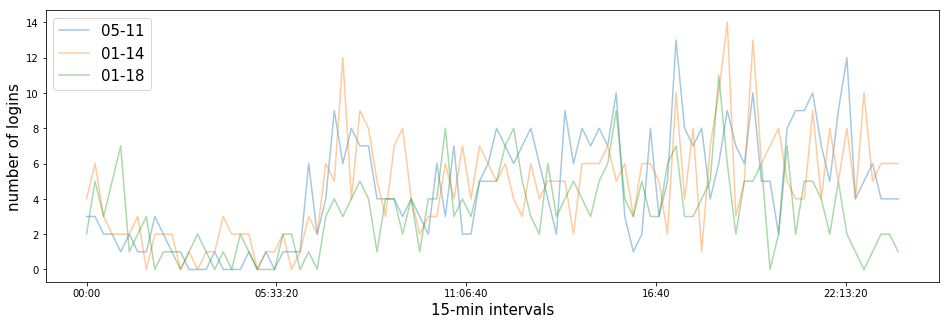

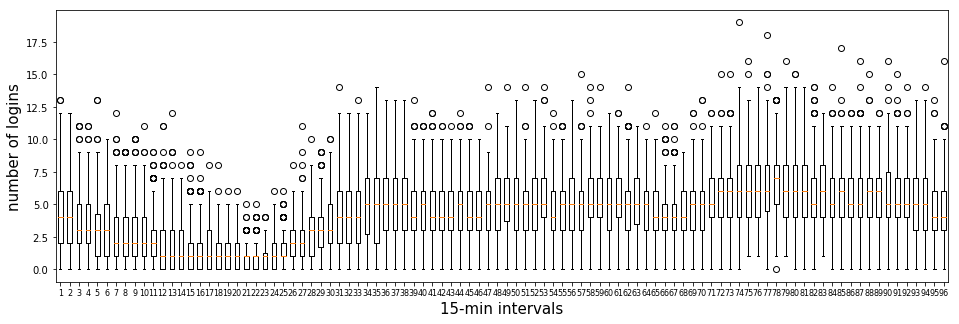

In [7]:
plt.figure(figsize=(16,5))
plt.plot(fif_df.log_time, fif_df['count'])
plt.ylabel('number of logins', fontsize = 15)
plt.xlabel('15-min intervals', fontsize = 15)
plt.show()

x = rand.sample(fif_df.day_month.tolist(),  3)   # Pick a random item from the list
plt.figure(figsize=(16,5))
temp = fif_df[fif_df.day_month == x[0]]
plt.plot( temp['hour'], temp['count'], alpha = .4, label = x[0])
temp = fif_df[fif_df.day_month ==  x[1]]
plt.plot(temp['hour'], temp['count'], alpha = .4, label =  x[1])
temp = fif_df[fif_df.day_month ==  x[2]]
plt.plot( temp['hour'], temp['count'], alpha = .4, label =  x[2])
plt.legend(fontsize = 15)
plt.ylabel('number of logins', fontsize = 15)
plt.xlabel('15-min intervals', fontsize = 15)


plt.figure(figsize=(16,5))
interval_list = []
for i in sorted(fif_df['hour'].unique()):
    temp = fif_df[fif_df['hour'] == i]
    interval_list.append(temp['count'].tolist())

plt.boxplot(interval_list)
plt.xticks(fontsize = 8)
plt.ylabel('number of logins', fontsize = 15)
plt.xlabel('15-min intervals', fontsize = 15)
plt.show()

In order to see how the descriptive attributes of the number of logins is changing in different intervals across all days, I plot the mean, mean, and the standard deviation. In the plot on the left, we see that the mean and median are either going hand to hand, or mean is larger than the median which is usually due to the skewness of the data. Moreover, the standard deviation is minimum when mean and median are minimum and later is slightly oscillating around a constant number of 2.2. If we remove the outliers, I expect to see that the mean and median converge and get close to each other. So, I write a function, called *remove_outliers* and recalculate the mean. As shown in plot on the right, mean and median are getting almost identical through 96 intervals.

I store the averaged data (after removing outliers) in a data frame, caller *final_df* for further use.

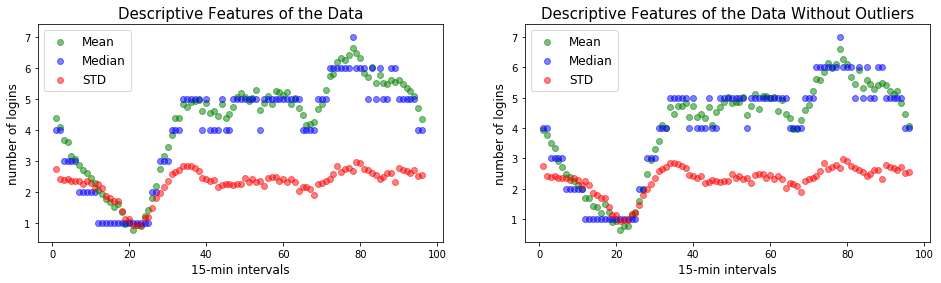

In [48]:
plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)

c = 1
for i in range(len(interval_list)):
    
    plt.scatter([c], np.mean(interval_list[i]), marker = 'o', color = 'green', label = 'Mean', alpha = 0.5)
    plt.scatter([c], np.median(interval_list[i]), marker = 'o', color = 'blue', label = 'Median', alpha = 0.5)
    plt.scatter([c], np.std(interval_list[i]), marker = 'o', color = 'red', label = 'STD', alpha = 0.5)
    
    if i == 0:
        plt.legend(fontsize = 12)
        plt.xlabel('15-min intervals', fontsize = 12)
        plt.ylabel('number of logins', fontsize = 12)
        plt.title('Descriptive Features of the Data', fontsize = 15)
    c += 1
    

def remove_outliers(data, m = 2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

plt.subplot(1, 2, 2)
c = 1
for i in range(len(interval_list)):

    plt.scatter([c], np.mean(remove_outliers(np.array(interval_list[i]))), marker = 'o', color = 'green', label = 'Mean', alpha = 0.5)
    plt.scatter([c], np.median(interval_list[i]), marker = 'o', color = 'blue', label = 'Median', alpha = 0.5)
    plt.scatter([c], np.std(interval_list[i]), marker = 'o', color = 'red', label = 'STD', alpha = 0.5)
    if i == 0:
        plt.legend(fontsize = 12)
        plt.xlabel('15-min intervals', fontsize = 12)
        plt.ylabel('number of logins', fontsize = 12)
        plt.title('Descriptive Features of the Data Without Outliers', fontsize = 15)     
    c += 1
    
final_df = pd.DataFrame(columns=['time_intervals','cat_intervals', 'mean_count'], index = np.arange(0, len(interval_list), 1))
for i in range(len(interval_list)):
    final_df.time_intervals[i] = sorted(fif_df['hour'].unique())[i]
    final_df.cat_intervals[i] = i+1
    final_df.mean_count[i] = math.ceil(np.mean(remove_outliers(np.array(interval_list[i]))))

I also aggregate the data into daily, weekly, and monthly intervals to check wether there is any pattern or trend. We again see three major drops in the beginning of Feburary, March, and Agust. There are also two local miminums at the beginning of the June and July. The fact the we see these sharp declines at the begininng of the months is noteworthy. One may want the investigate the cause of this issue and make necessary changes in some aspacts, including pricing, marketing, etc.. 

I group the average daily data into each weekday and show the results in another plot below. On Monday, the least number of logins is happening. It is monotonically increasing until Friday which is the pick of demand. After Friday, the number of logins is going down and the logins on Sunday is comparable with the number of logins on Monday. Finally, I show the weekly and monthly aggregation of the login data. The same declines in the number of logins are also can be seen in the plots for these two aggregation. In May, the maximum number of logins was documented which could be due to the summer-time and people being on vacation. 

In [ ]:
# daily aggregation
daily_login = {}
s = datetime(2010, 1, 1, 0, 0, 0)
c = 1
while s < end_time:
    daily_login.setdefault(s,0)
    s += timedelta(days = 1)

print 'Number of days: ', len(daily_login)

t = datetime(2010, 1, 1, 0, 0, 0)
for i in sorted(daily_login.keys()):
    temp = df.loc[(df.login_time >= t) & (df.login_time < t+timedelta(days = 1))]
    
    daily_login[i] = len(temp)
    t += timedelta(days = 1)

count_df = pd.DataFrame.from_dict(daily_login, orient='index' )
count_df['log_time'] = count_df.index
count_df['count'] = count_df[0]
count_df = count_df.drop(columns=[0])
count_df.reset_index(drop = True, inplace = True)
count_df = count_df.sort_values(by = ['log_time'])
count_df.reset_index(drop = True, inplace = True)
count_df['day_month'] = count_df['log_time'].dt.strftime('%m-%d')
count_df['month'] = count_df['log_time'].dt.strftime('%m')
count_df['week_day'] = count_df.log_time.dt.dayofweek
daily_df = count_df.copy()

plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
plt.plot(daily_df.log_time, daily_df['count'], label = 'Daily login')
plt.legend(fontsize = 12, loc = 'upper right' )
plt.ylabel('number of logins', fontsize = 15)
plt.title('Total Daily Logins', fontsize = 15)


plt.subplot(1, 2, 2)

mean_daily_demand = daily_df.groupby(by = ['week_day'])['count'].mean()
mean_daily_demand.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.plot(mean_daily_demand.index , mean_daily_demand, '-o', color = 'orange')
plt.ylabel('number of logins', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Average Daily Logins over WeekDays', fontsize = 15)
plt.show()

Number of weeks: 35


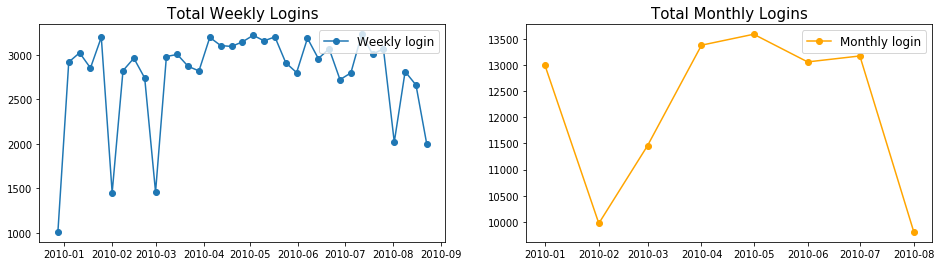

In [52]:
# weekly aggregation
weekly_login = {}
s = datetime(2009, 12, 28, 0, 0, 0)
c = 1
while s < end_time:
    weekly_login.setdefault(s,0)
    s += timedelta(days = 7)
print 'Number of weeks:' ,len(weekly_login)

t = datetime(2009, 12, 28, 0, 0, 0)
for i in sorted(weekly_login.keys()):
    temp = df.loc[(df.login_time >= t) & (df.login_time < t+timedelta(days = 7))]
    
    weekly_login[i] = len(temp)
    t += timedelta(days = 7)
              
count_df = pd.DataFrame.from_dict(weekly_login, orient='index' )
count_df['log_time'] = count_df.index
count_df['count'] = count_df[0]
count_df = count_df.drop([0],axis=1)
count_df.reset_index(drop = True, inplace = True)
count_df = count_df.sort_values(by = ['log_time'])
count_df.reset_index(drop = True, inplace = True)
count_df['day_month'] = count_df['log_time'].dt.strftime('%m-%d')
count_df['month'] = count_df['log_time'].dt.strftime('%m')
count_df['week_day'] = count_df.log_time.dt.dayofweek
weekly_df = count_df.copy()


plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
plt.plot(weekly_df.log_time, weekly_df['count'], '-o', label = 'Weekly login')
plt.legend(fontsize = 12, loc = 'upper right' )
plt.title('Total Weekly Logins', fontsize = 15)



# Monthly aggregation
monthly_login = {}
s = datetime(2010, 1, 1, 0, 0, 0)
c = 1
while s < end_time:
    monthly_login.setdefault(s,0)
    s += relativedelta(months=+1)

t = datetime(2010, 1, 1, 0, 0, 0)
for i in sorted(monthly_login.keys()):
    temp = df.loc[(df.login_time >= t) & (df.login_time < t+relativedelta(months=+1))]
    monthly_login[i] = len(temp)
    t += relativedelta(months=+1)
    
        
count_df = pd.DataFrame.from_dict(monthly_login, orient='index' )
count_df['log_time'] = count_df.index
count_df['count'] = count_df[0]
count_df = count_df.drop([0], axis=1)
count_df.reset_index(drop = True, inplace = True)
count_df = count_df.sort_values(by = ['log_time'])
count_df.reset_index(drop = True, inplace = True)
count_df['day_month'] = count_df['log_time'].dt.strftime('%m-%d')
count_df['month'] = count_df['log_time'].dt.strftime('%m')
count_df['week_day'] = count_df.log_time.dt.dayofweek
monthly_df = count_df.copy()

plt.subplot(1, 2, 2)
plt.plot(monthly_df.log_time, monthly_df['count'], '-o', label = 'Monthly login', color = 'orange')
plt.legend(fontsize = 12, loc = 'upper right' )
plt.title('Total Monthly Logins', fontsize = 15)
plt.show()

In [29]:
sorted(fif_df['month'].unique())
fif_df.head()

,log_time,count,day_month,month,week_day,hour,day_hour
0,2010-01-01 00:00:00,3,01-01,01,4,00:00:00,01 00:00:00
1,2010-01-01 00:15:00,3,01-01,01,4,00:15:00,01 00:15:00
2,2010-01-01 00:30:00,7,01-01,01,4,00:30:00,01 00:30:00
3,2010-01-01 00:45:00,7,01-01,01,4,00:45:00,01 00:45:00
4,2010-01-01 01:00:00,5,01-01,01,4,01:00:00,01 01:00:00


Below, I plot the 15-min interval login counts for each month separately. We can see that there is a clear trend in each month regarding the demand in 15-min intervals. In the last plot, I overlay all months on top of each other and it is shown that in different months, the same pattern of demand is happening. I store this average monthly data in a data frame, called *final_monthly_df* for further use.

In [22]:
# temp = fif_df[fif_df['month'] == sorted(fif_df['month'].unique())[0]]
# np.arange(0, len(temp),1)
# nn = {'t': 'Jan', 'tt': 'Feb'}
# nn[1]
sorted(fif_df['month'].unique())

[u'01', u'02', u'03', u'04', u'05', u'06', u'07', u'08']

In [25]:
type(fif_df['log_time'][0])

pandas._libs.tslib.Timestamp

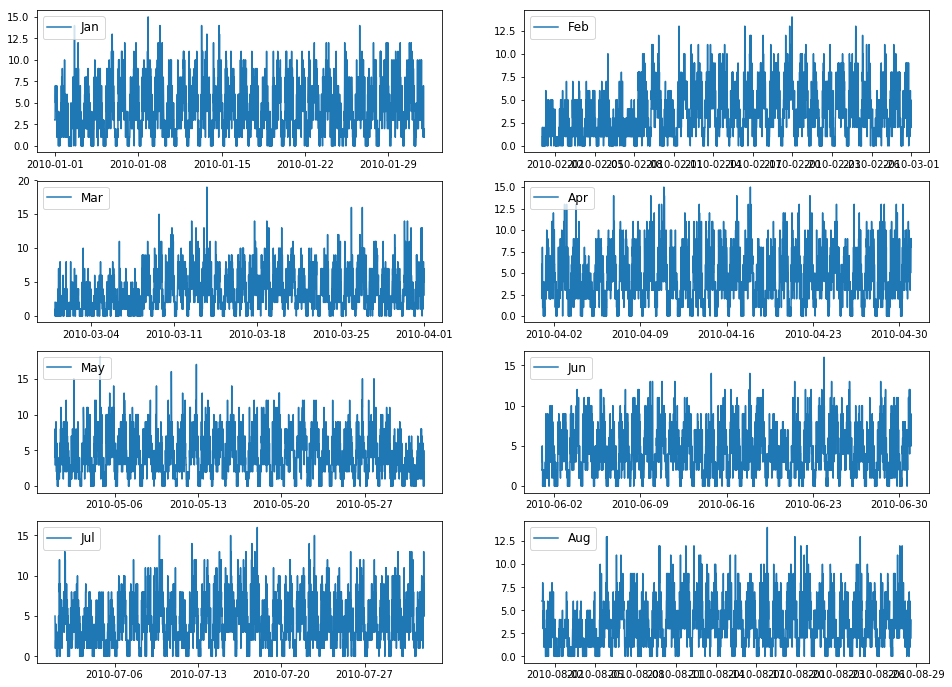

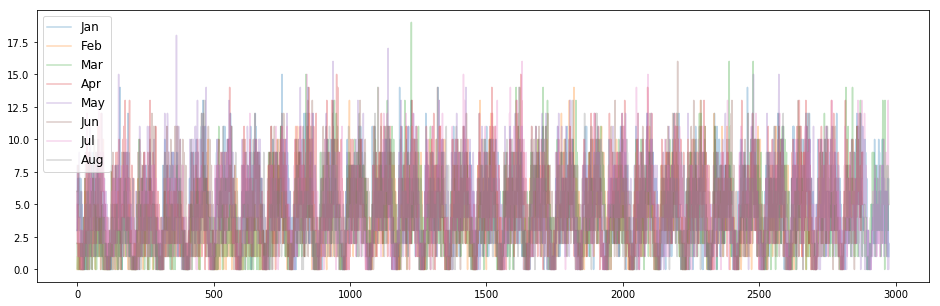

In [61]:
labels = {'01': 'Jan', '02': 'Feb', '03': 'Mar','04': 'Apr','05': 'May','06': 'Jun','07': 'Jul','08': 'Aug'}

plt.figure(figsize=(16,12))

for i in sorted(fif_df['month'].unique()):
    plt.subplot(4, 2, int(i))
    temp = fif_df[fif_df['month'] == i]
    plt.plot(temp.log_time, temp['count'], label = labels[i])#, '-o')
    plt.legend(fontsize = 12, loc = 'upper left')

plt.figure(figsize=(16,5))
for i in sorted(fif_df['month'].unique()):
    temp = fif_df[fif_df['month'] == i]
    plt.plot(np.arange(0, len(temp),1), temp['count'], label = labels[i], alpha = .3)#, '-o')
    plt.legend(fontsize = 12)
    
final_monthly_df = pd.DataFrame(fif_df.groupby(by = 'day_hour')['count'].mean())
final_monthly_df['log_time'] = final_monthly_df.index
final_monthly_df.reset_index(drop = True, inplace = True)

## Predicive Analysis
In order to develop a predictive model to predict the future demand, I look at the data from two point of views:
1. Model A: averaged data of 2976 fifteen-min intervals accross all months (data stored in *final_monthly_df*)
2. Model B: data of 23004 fifteen-min intervals accross all days (data stored in *fif_df*)

I use Autoregressive Integrated Moving Average (ARIMA) Model to create a predictive model. First step before applying an ARIMA model is to check whether the data is stationary which means that its statistical properties such as mean, variance remain constant over time. I test this assumption using (1) visualization, and (2) hypothesis testing (null hypothesis: data is non-stationary). I write a function, called *test_stationarity*, to assess the stationarity assumption using both visualization and Dickey-Fuller Test.

1. Plotting Rolling Statistics: I plot the moving average and moving standard deviation to see if it changes with time. To calculate the  moving average/variance at each interval, I take the average/variance of the last four intervals. 
2. Dickey-Fuller Test: This is one of the statistical tests for checking stationarity in which the null hypothesis is that the data is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the Test Statistic is less than the Critical Value, one can reject the null hypothesis and say that the series is stationary.  

We can see that for both models A and B, the standard deviation is small and the rolling mean is not changing that much with time. Also the p-values for the Dickey-Fuller Test for both data are smaller than the threshold of 0.05 which means the null hypothesis is rejected and the data in both models are stationary.

On the other hand, decomposing data A and B into trend, seasonality and residuals, we can see that we have a daily (96 intervals) seasonality. This observation is useful in fitting a predictive model.

I try ARIMA model to fit a model for data A and B. In model A, to specify the number of AR terms (p) and the number of MA terms (q), I use Partial Autocorrelation Function and Autocorrelation Function, respectively. In PACF plot, the lag value is where the PACF crosses the upper CI for the first time. I assume p = 1. In ACF plot, the lag value is where the ACF crosses the upper CI for the first time. I assume q = 1. I run three models for different combinations of p and q and calculate the RSS. For data A, the third model results in the smallest RSS. 

However, in order to find the optimal values for parameters p, q, and d, I follow a grid search approach and run an SARIMAX model to search through all possible combinations of p, q, and d when p = q = d = range(0,2). I also search for the best value for seasonality parameters (P, Q, D, and S). For S, I search through 4, 12, 24, 96. The maximum lag in the model is referred to as p. Regarding q, the assumption is current error depends on the previous with some lag, which is referred to as q. d is the number of differences included in the model to make sure the data is stationary. S equals the season period length of the series. P is the order of autoregression for seasonal component of the model, again can be derived from PACF, but this time you need to look at the number of significant lags. Q is for the moving average model of the seasonal component. D is the order of seasonal integration which can be equal to 1 or 0, depending on whether seasonal differences were applied or not. We expect that S = 96 gives a better fit in predicting the future login counts.

Among all possible models, I compare the AIC's and keep the combination of paramaters that result in the minimum AIC.

In [54]:
def test_stationarity(timeseries, w = 4, plot = True):

    rm = timeseries.rolling(window=w).mean()
    rs = timeseries.rolling(window=w).std()

    x = np.arange(0, len(timeseries),1)
    plt.figure(figsize = (8,5))
    plt.plot(x,timeseries, color='blue',label='Original', alpha = .3)
    plt.plot(x,rm, color='red', label='Rolling Mean', alpha = .3)
    plt.plot(x,rs, color='black', label = 'Rolling Std', alpha = .3)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Hypothesis testing using Dickey-Fuller test:

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    if dftest[1] < 0.05:
        print 'Null hypothesis (data is non-stationary) is rejected. '
    else:
        print 'Null hypothesis (data is non-stationary) cannot be rejected. '

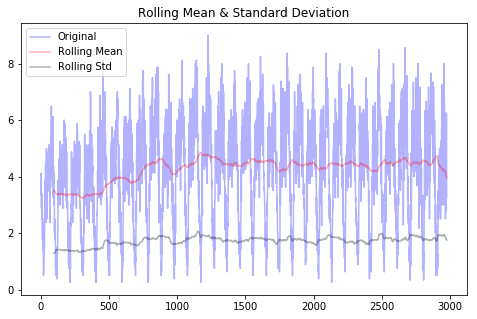

Results of Dickey-Fuller Test:
Test Statistic                -1.245907e+01
p-value                        3.438214e-23
#Lags Used                     2.200000e+01
Number of Observations Used    2.953000e+03
Critical Value (5%)           -2.862519e+00
Critical Value (1%)           -3.432566e+00
Critical Value (10%)          -2.567291e+00
dtype: float64
Null hypothesis (data is non-stationary) is rejected. 


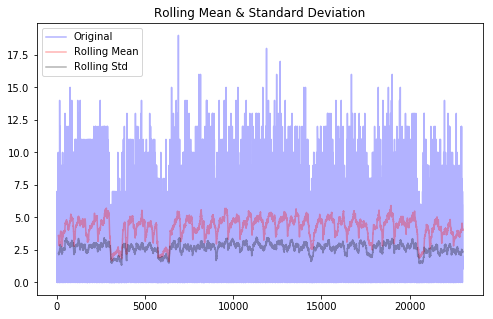

Results of Dickey-Fuller Test:
Test Statistic                   -21.467619
p-value                            0.000000
#Lags Used                        47.000000
Number of Observations Used    22956.000000
Critical Value (5%)               -2.861666
Critical Value (1%)               -3.430635
Critical Value (10%)              -2.566837
dtype: float64
Null hypothesis (data is non-stationary) is rejected. 


In [55]:
test_stationarity(final_monthly_df['count'], w = 96)
test_stationarity(fif_df['count'], w = 96)

In [74]:
# temp = final_monthly_df.copy()
# temp.index = final_monthly_df.log_time.tolist()
# temp 
len(fif_df['count']),len(final_monthly_df['count'])/96

(23004, 31)

In [66]:
type(final_monthly_df.log_time[0])

unicode

In [70]:
temp.head()

,count,log_time
01 00:00:00,3.375,01 00:00:00
01 00:15:00,3.375,01 00:15:00
01 00:30:00,3.375,01 00:30:00
01 00:45:00,4.125,01 00:45:00
01 01:00:00,2.875,01 01:00:00


In [72]:
# dt.strftime('%d %H:%M:%S')



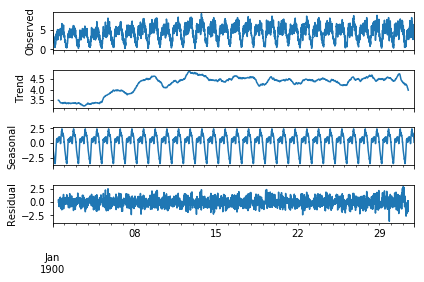

In [77]:
final_monthly_df.log_time = pd.to_datetime(final_monthly_df.log_time, format = '%d %H:%M:%S')
temp = final_monthly_df.copy()
temp.index = final_monthly_df.log_time.tolist()

decomposition = sm.tsa.seasonal_decompose(temp['count'], freq = 96)#, model='additive')
decomposition_plot = decomposition.plot()
plt.show()

# plt.plot(decomposition.seasonal[0:1000])
# plt.show()

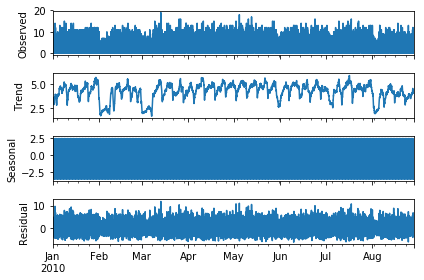

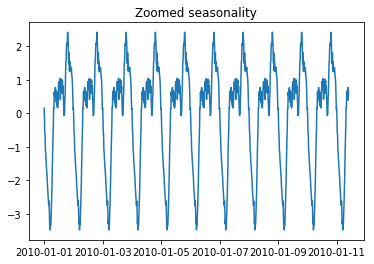

In [63]:
temp = fif_df.copy()
temp.index = fif_df.log_time.tolist()
decomposition = sm.tsa.seasonal_decompose(temp['count'], freq = 96)#, model='additive')
decomposition_plot = decomposition.plot()
plt.show()

plt.plot(decomposition.seasonal[0:1000])
plt.title('Zoomed seasonality', fontsize  = 12)
plt.show()


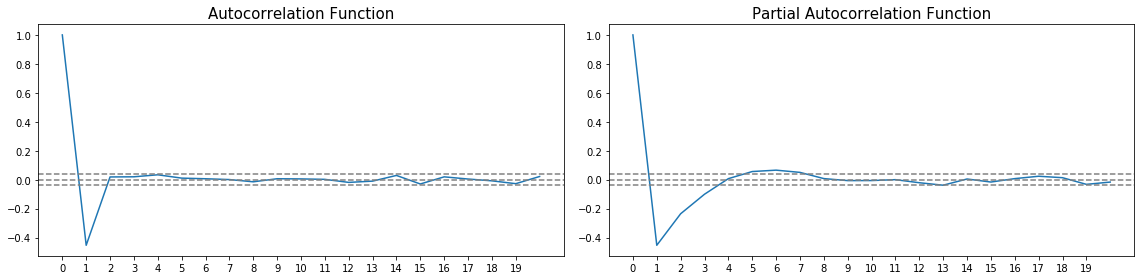

In [58]:
timeseries = final_monthly_df['count']
diff = timeseries - timeseries.shift()
diff.dropna(inplace = True)
n = 20
lag_acf = acf(diff, nlags=n)
lag_pacf = pacf(diff, nlags=n, method='ols')
plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.xticks(np.arange(0,n,1))
plt.title('Autocorrelation Function', fontsize = 15)


#Plot PACF: 
plt.subplot(1, 2, 2)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function', fontsize = 15)
plt.xticks(np.arange(0,n,1))
plt.tight_layout()

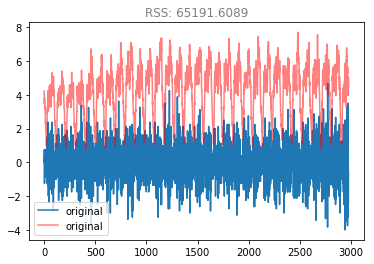

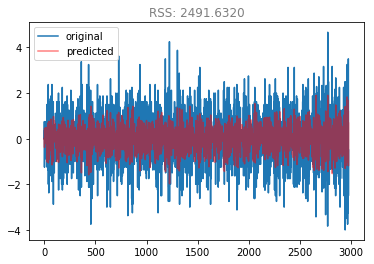

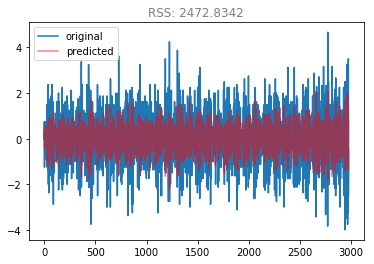

In [19]:
model = ARIMA(np.array(timeseries), order=(1, 0, 1))  
results_AR = model.fit(disp=-1)
x = np.arange(0, len(diff),1)
plt.plot(x, diff, label = 'original')
plt.plot(results_AR.fittedvalues, color='red', alpha = .5, label = 'original')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues[1:]-diff)**2), alpha = .5)
plt.legend()
plt.show()


model = ARIMA(np.array(timeseries), order=(0, 1, 1))  
results_AR = model.fit(disp=-1)
x = np.arange(0, len(diff),1)
plt.plot(x, diff, label = 'original')
plt.plot(results_AR.fittedvalues, color='red', alpha = .5, label = 'predicted')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-diff)**2), alpha = .5)
plt.legend()
plt.show()

model = ARIMA(np.array(timeseries), order=(1, 1, 1))  
results_AR = model.fit(disp=-1)
x = np.arange(0, len(diff),1)
plt.plot(x,diff, label = 'original')
plt.plot(results_AR.fittedvalues, color='red', alpha = .5, label = 'predicted')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-diff)**2), alpha = .5)
plt.legend()
plt.show()

### Model A

For data A, I make a subset of the data as training set - to avoid overfitting - and search in the space of parameters to find the best set of paramaters. The trainig set contains the first 2000 data points and the test set contains the rest of the data. Best paramaters are corresponding to the minimum AIC. As shown the best set of parameters are ((p,q,d), (P,Q,D,S)) = ((1, 0, 1), (0, 1, 1, 24)) and the smallest AIC is 4251.43. Now, I use the fitted model using the training set to predict the login counts in the test set to estimate the RMSE of the model. As shown below the RMSE is 0.91. I also forecast the number of logins in the next 200 intervals as the results for first 4 intervals are printed. The forcasted demands along with the forecasted confidence interval are plotted.

Looking at the diagnostic plots, the residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself. Moreover, we see that the residuals are more or less normally distirbuted. The QQ-plot on the bottom left shows that the ordered distribution of residuals follows the linear trend of the samples taken from a standard normal distribution which is again an indication that the residuals are normally distributed.





In [4]:
train = final_monthly_df.iloc[0:2000]
test = final_monthly_df.iloc[2001:]
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
s = [4, 12, 24, 96]

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, s))]

    
y = train['count'].tolist()
aic_monthly_train = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        c +=1 
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            aic_monthly_train[(param,param_seasonal)] = results.aic
        except:
            continue

print 'Best parameters: ', min(aic_monthly_train, key=aic_monthly_train.get)
print 'Minimum AIC: ', min(aic_monthly_train.values()) 


Best parameters:  ((1, 0, 1), (0, 1, 1, 96))
Minimum AIC:  4251.4288425


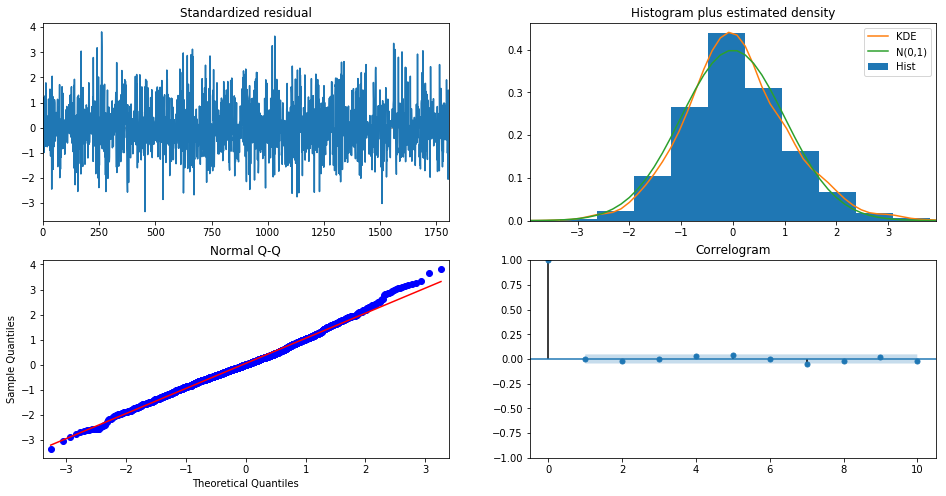

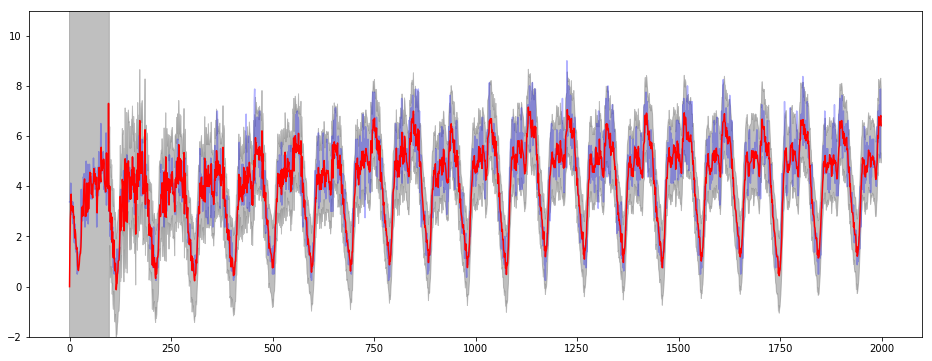

In [16]:
# monthly 96
# ((1, 0, 1), (0, 1, 1, 96))

y = train['count'].tolist()
mod_A = sm.tsa.statespace.SARIMAX(y, order=(1, 0, 1), seasonal_order=(0, 1, 1, 96), enforce_stationarity=False,
                                            enforce_invertibility=False)

res_A = mod_A.fit()
print res_A.summary()

res_A.plot_diagnostics(figsize=(16, 8))
plt.show()

predict_dy  = res_A.get_prediction(start = 0)
predict_dy_ci = predict_dy.conf_int()



plt.figure(figsize = (16,6))

plt.fill_between(np.arange(0, len(train),1), predict_dy_ci[:,0], predict_dy_ci[:,1], color = 'grey', alpha = .5)
plt.plot(np.arange(0,len(train),1), train['count'], color = 'blue', alpha = .3)
plt.plot(np.arange(0, len(train),1), predict_dy.predicted_mean, color = 'red')#, alpha = .3)
plt.ylim(-2,11)
plt.show()


In [18]:
forecasted_test = res_A.get_forecast(steps = len(test))
delta = np.abs(np.array(test['count'])-np.array(forecasted_test.predicted_mean))
RMSE = np.sqrt(np.mean(delta**2))
print 'RMSE = ', RMSE
print 'Predicting the next four intervals ....'

RMSE =  0.9188247751870223
Predicting the next four intervals ....


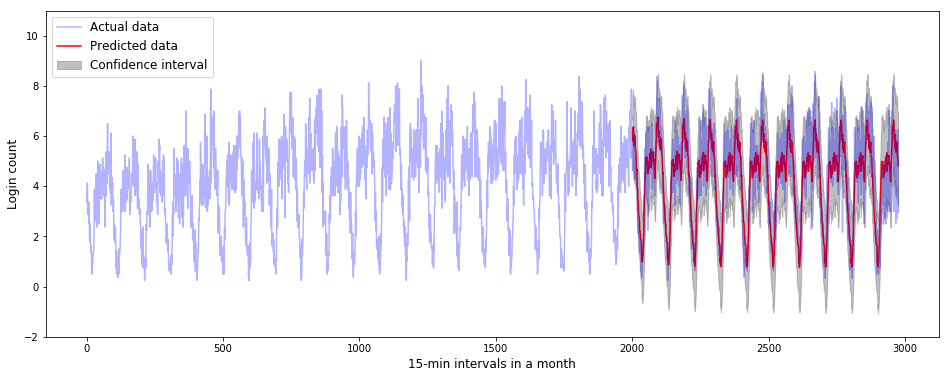

In [32]:
forecasted_test_ci = forecasted_test.conf_int()

plt.figure(figsize = (16,6))

plt.plot(np.arange(0,len(train),1), train['count'], color = 'blue', alpha = .3, label = 'Actual data')
plt.fill_between(np.arange(len(train)+1, len(final_monthly_df),1), forecasted_test_ci[:,0], forecasted_test_ci[:,1], color = 'grey', alpha = .5, label = 'Confidence interval')

plt.plot(np.arange(len(train)+1, len(final_monthly_df),1),forecasted_test.predicted_mean, color = 'red', label = 'Predicted data' )
plt.legend(fontsize = 12)

plt.plot(np.arange(len(train)+1, len(final_monthly_df),1),test['count'], color = 'blue', alpha = .3 , label = 'Actual data')


plt.ylim(-2,11)
plt.ylabel('Login count', fontsize = 12)
plt.xlabel('15-min intervals in a month', fontsize = 12)
plt.show()

Forcasted login counts in the next 4 intervals:  [6.13584420771843, 6.174830496569969, 6.356888035827901, 5.783190425005706]


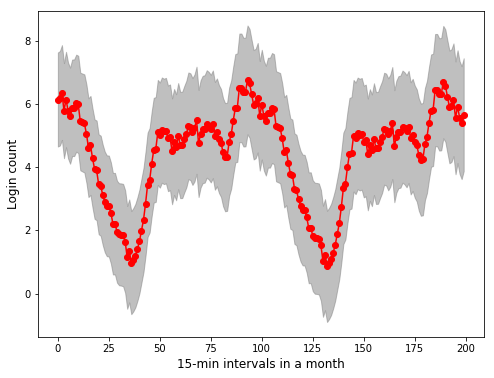

In [36]:
future_A = res_A.get_forecast(steps = 200)
print 'Forcasted login counts in the next 4 intervals: ',future_A.predicted_mean.tolist()[0:4]

future_A_ci = future_A.conf_int()
plt.figure(figsize = (8,6))
plt.fill_between(np.arange(0, len(future_A_ci),1), future_A_ci[:,0], future_A_ci[:,1], color = 'grey', alpha = .5)
plt.plot(np.arange(0, len(future_A_ci),1), future_A.predicted_mean,'-o', color = 'red',  )#, alpha = .3)
plt.ylabel('Login count', fontsize = 12)
plt.xlabel('15-min intervals in a month', fontsize = 12)
plt.show()

### Model B
While, it seems that model A is doing well in predicting the number of logins, the fact that I used an aggregated data over months may reduce the power of the obtained model, especially if there is any between-month variation. To tackle this problem, rather than aggregating data, I use the raw data - only aggregated for 15-min intervals - to develop a predictive model. I take the same approach as in model A to find the best set of paramaters. The best parameters using data B are ((p,q,d), (P,Q,D,S)) = ((1, 0, 1), (0, 1, 1, 96)) and the smallest AIC is 73365.71. Finding the best parametrs for model B, I was not able to move forward and tun furthur analysis since the resources on my PC are limited.

In [6]:
train = fif_df.iloc[0:17000]       
test = fif_df.iloc[17001:]
warnings.filterwarnings("ignore")
p = d = q = range(0, 2)
s = [4, 12, 24, 96]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdqs = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q, s))]
y = train['count'].tolist()
aic_train = {}
c = 0
for param in pdq:
    for param_seasonal in seasonal_pdqs:
        mod = 0
        results = 0
        c +=1 
        print c, param, param_seasonal
        if c > 38 and sum(param_seasonal) != 93:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                aic_train[(param,param_seasonal)] = results.aic
                
                
            except:
                continue    
print 'Best parameters: ', min(aic_train, key=aic_train.get)
print 'Minimum AIC: ', min(aic_train.values()) 

Best parameters:  ((1, 0, 1), (0, 1, 1, 96))
Minimum AIC:  73365.7147341


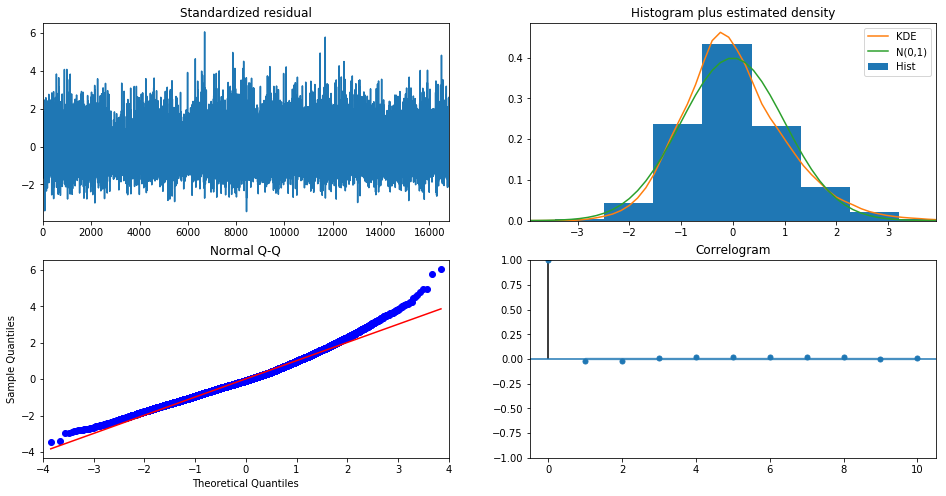

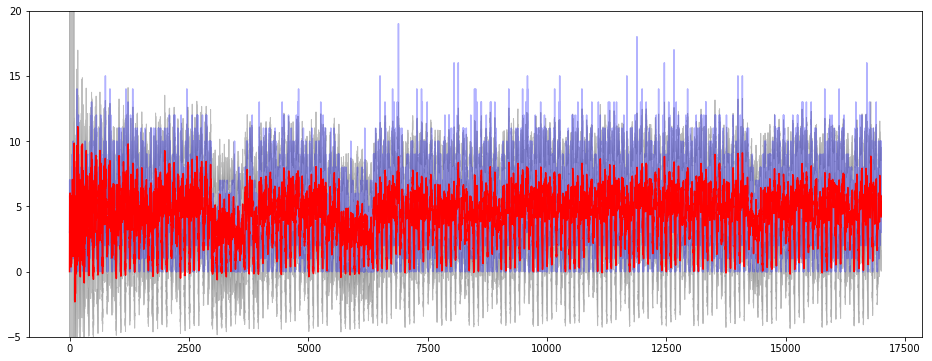

In [6]:
y = fif_df['count'].tolist()

#(1, 0, 1), (1, 0, 1, 24)

mod_B = sm.tsa.statespace.SARIMAX(y, order=(1, 0, 1), seasonal_order=(0, 1, 1, 96), enforce_stationarity=False,
                                            enforce_invertibility=False)

res_B = mod_B.fit(disp=False)
print res_B.summary()

res_B.plot_diagnostics(figsize=(16, 8))
plt.show()

predict_dy  = res_B.get_prediction(start = 0)
predict_dy_ci = predict_dy.conf_int()


plt.figure(figsize = (16,6))
plt.fill_between(np.arange(0, len(train),1), predict_dy_ci[:,0], predict_dy_ci[:,1], color = 'grey', alpha = .5)
plt.plot(np.arange(0,len(train),1), train['count'], color = 'blue', alpha = .3)
plt.plot(np.arange(0, len(train),1), predict_dy.predicted_mean, color = 'red')#, alpha = .3)
plt.ylim(-5,20)
plt.show()



In [ ]:
forecasted_test = res_A.get_forecast(steps = len(test))
delta = np.abs(np.array(test['count'])-np.array(forecasted_test.predicted_mean))
RMSE = np.sqrt(np.mean(delta**2))
print 'RMSE = ', RMSE
print 'Predicting the next four intervals ....'

forecasted_test_ci = forecasted_test.conf_int()

plt.figure(figsize = (16,6))

plt.plot(np.arange(0,len(train),1), train['count'], color = 'blue', alpha = .3, label = 'Actual data')
plt.fill_between(np.arange(len(train)+1, len(final_monthly_df),1), forecasted_test_ci[:,0], forecasted_test_ci[:,1], color = 'grey', alpha = .5, label = 'Confidence interval')

plt.plot(np.arange(len(train)+1, len(final_monthly_df),1),forecasted_test.predicted_mean, color = 'red', label = 'Predicted data' )
plt.legend(fontsize = 12)

plt.plot(np.arange(len(train)+1, len(final_monthly_df),1),test['count'], color = 'blue', alpha = .3 , label = 'Actual data')


plt.ylim(-2,11)
plt.ylabel('Login count', fontsize = 12)
plt.xlabel('15-min intervals in a month', fontsize = 12)
plt.show()


future_A = res_A.get_forecast(steps = 200)
print 'Forcasted login counts in the next 4 intervals: ',future_A.predicted_mean.tolist()[0:4]

future_A_ci = future_A.conf_int()
plt.figure(figsize = (8,6))
plt.fill_between(np.arange(0, len(future_A_ci),1), future_A_ci[:,0], future_A_ci[:,1], color = 'grey', alpha = .5)
plt.plot(np.arange(0, len(future_A_ci),1), future_A.predicted_mean,'-o', color = 'red',  )#, alpha = .3)
plt.ylabel('Login count', fontsize = 12)
plt.xlabel('15-min intervals in a month', fontsize = 12)
plt.show()


## Perscriptive Analysis

In the previous step, I developed two predictive models: model A for login counts for 2976 fifteen-min intervals averaged over all months, and model B for 23004 fifteen-min intervals starting from 2010-01-01 to 2010-08-28. I assessed the goodness of fit for each model via calculating the AIC and determined the best model parameters associated with the smallest AIC using the training set. I also calculated the RMSE for model A using the test set. While one cannot compare the AIC of model A with the AIC of model B - since thee models are trained using different sets of data -, the RMSE of model A can be compared with the RMSE of model B to select the better model. While due to the limited resources available, I was not able to run further analysis in model B and calculate RMSE, according to the obtained plots, one can say that the RSME of model B is more likely to be higher than model A's.
We can also see that the confidence interval (CI) over the number of logins in the test set in model A is tighter than in model B. The CI in model A only includes positive values; however, the CI for model B includes both positive and negative values. In spite of all these facts regarding model A and B, one still cannot reject model B in favor of model A. Because the data used in model A is averaged over all months and the potential monthly variations are already killed and the information is lost. Data A is cleaner than data B and consequently results in a better predictive performance. On the other hand, in data A we have the full information of any sort of preiodic variation. Therefore, model B can be a better model after all to predict the future demand.

The fact that we only have the login information for first eight months of the year can undermine the power of the predictive model since the potential effect of the cold weather on the demand is ignored. Enlarging the dataset by including the data of remaining months can enrich the power of the predictive model. Widening the grid search to find the best set of parametrs also can lead us finding a better model to forecast the future demand. Another way to improve the predictive model is to apply a cross-validation approach to eliminate overfitting. Other machine learning methods such as Convolutional Neural Networks (CNNs) and Long Short-Term Memory Networks (LSTMs) also can be used to develop a predictive model.




# Part 2: Programming Exercise

Say we have a set of cuisines, each of which can be represented by a letter of the alphabet, and
a set of dishes within each cuisine, each of which can be represented by a number. Each
cuisine has a different number of possible dishes available. Note: this exercise needs to be
completed without the use of library functions that perform the enumeration.


A menu consists of a set of dishes chosen from the different cuisines. A menu can be
represented by a list of dishes such as “A3 B11 C4”. Assume that each menu contains exactly
one dish from each cuisine and all cuisines are included. Write a program that takes the number
of cuisines and the number of dishes available within each cuisine as input and lists all possible
menus as output.

In [68]:
cuisine_A = ['A1', 'A2', 'A3']
cuisine_B = ['B4', 'B5', 'B6', 'B7']
cuisine_C = ['C8', 'C9']
cuisine_D = ['D10', 'D11']

all_cuisines = [cuisine_A, cuisine_B, cuisine_C, cuisine_D]

all_menus = [[]]
for i in all_cuisines:
    temp = []
    for j in i:
        for k in all_menus:
            temp.append(k+[j])
    all_menus = temp

print 'Number of all possible menus: ', len(all_menus), '\n'
print all_menus

Number of all possible menus:  48 

[['A1', 'B4', 'C8', 'D10'], ['A2', 'B4', 'C8', 'D10'], ['A3', 'B4', 'C8', 'D10'], ['A1', 'B5', 'C8', 'D10'], ['A2', 'B5', 'C8', 'D10'], ['A3', 'B5', 'C8', 'D10'], ['A1', 'B6', 'C8', 'D10'], ['A2', 'B6', 'C8', 'D10'], ['A3', 'B6', 'C8', 'D10'], ['A1', 'B7', 'C8', 'D10'], ['A2', 'B7', 'C8', 'D10'], ['A3', 'B7', 'C8', 'D10'], ['A1', 'B4', 'C9', 'D10'], ['A2', 'B4', 'C9', 'D10'], ['A3', 'B4', 'C9', 'D10'], ['A1', 'B5', 'C9', 'D10'], ['A2', 'B5', 'C9', 'D10'], ['A3', 'B5', 'C9', 'D10'], ['A1', 'B6', 'C9', 'D10'], ['A2', 'B6', 'C9', 'D10'], ['A3', 'B6', 'C9', 'D10'], ['A1', 'B7', 'C9', 'D10'], ['A2', 'B7', 'C9', 'D10'], ['A3', 'B7', 'C9', 'D10'], ['A1', 'B4', 'C8', 'D11'], ['A2', 'B4', 'C8', 'D11'], ['A3', 'B4', 'C8', 'D11'], ['A1', 'B5', 'C8', 'D11'], ['A2', 'B5', 'C8', 'D11'], ['A3', 'B5', 'C8', 'D11'], ['A1', 'B6', 'C8', 'D11'], ['A2', 'B6', 'C8', 'D11'], ['A3', 'B6', 'C8', 'D11'], ['A1', 'B7', 'C8', 'D11'], ['A2', 'B7', 'C8', 'D11'], ['A3', 'B7', 'C8',